### HyDE
🧠 What is HyDe?

HyDE (Hypothetical Document Embeddings) is a retrieval technique where, instead of embedding the user’s query directly, you first generate a hypothetical answer (document) to the query using an LLM — and then embed that hypothetical document to search your vector store.

➡️ HyDE bridges the gap between user intent and relevant content, especially when:

1. Queries are short
2. Language mismatch between query and documents
3.You want to retrieve based on answer content, not question words

In [16]:
from langchain_community.document_loaders import WikipediaLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma

In [18]:
# 1. Load and chunk your dataset
chunk_size = 300
chunk_overlap = 100

# loading data
loader = WikipediaLoader(query="Steve Jobs", load_max_docs=5)
documents = loader.load()

# text splitting
text_splitter = RecursiveCharacterTextSplitter(chunk_size = chunk_size, chunk_overlap = chunk_overlap)
docs = text_splitter.split_documents(documents=documents)
docs

[Document(metadata={'title': 'Steve Jobs', 'summary': 'Steven Paul Jobs (February 24, 1955 – October 5, 2011) was an American businessman, inventor, and investor best known for co-founding the technology company Apple Inc. Jobs was also the founder of NeXT and chairman and majority shareholder of Pixar. He was a pioneer of the personal computer revolution of the 1970s and 1980s, along with his early business partner and fellow Apple co-founder Steve Wozniak.\nJobs was born in San Francisco in 1955 and adopted shortly afterwards. He attended Reed College in 1972 before withdrawing that same year. In 1974, he traveled through India, seeking enlightenment before later studying Zen Buddhism. He and Wozniak co-founded Apple in 1976 to further develop and sell Wozniak\'s Apple I personal computer. Together, the duo gained fame and wealth a year later with production and sale of the Apple II, one of the first highly successful mass-produced microcomputers. \nJobs saw the commercial potential 

In [19]:
# 2. Build vector store
from langchain.vectorstores import FAISS
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vectorstore = FAISS.from_documents(docs, embeddings)

In [20]:
# 3. Set up the LLM you’ll use to generate hypothetical answers
import os
from dotenv import load_dotenv
load_dotenv()
from langchain.chat_models import init_chat_model
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
llm = init_chat_model("groq:gemma2-9b-it")

In [21]:
from langchain.vectorstores import Chroma
## creating vector store
db = Chroma.from_documents(documents = docs,embedding=embeddings,persist_directory = "output/steve_jobs_for_hyde.db")
##create the retriever
base_retriever=db.as_retriever(search_kwargs = {"k":5})

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [22]:
from langchain_core.output_parsers import StrOutputParser
## Generating a prompt gor generating HyDE
from langchain.prompts.chat import SystemMessagePromptTemplate, ChatPromptTemplate

def get_hyde_doc(query):
    template = """Imagine you are an expert writing a detailed explanation on the topic: '{query}'
    create a hypothetical answer for the topic"""

    system_message_prompt = SystemMessagePromptTemplate.from_template(template = template)
    chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt])
    messages = chat_prompt.format_prompt(query = query).to_messages()
    print(messages)
    response = llm.invoke(messages)
    hypo_doc = response.content
    return hypo_doc

In [23]:
query = 'When was Steve Jobs fired from Apple?'
print(get_hyde_doc(query=query))

[SystemMessage(content="Imagine you are an expert writing a detailed explanation on the topic: 'When was Steve Jobs fired from Apple?'\n    create a hypothetical answer for the topic", additional_kwargs={}, response_metadata={})]
## The Fall and Rise of a Tech Titan: Steve Jobs' Dismissal from Apple 

While Steve Jobs is widely celebrated as a visionary leader and the driving force behind Apple's success, his journey with the company wasn't a straight path to triumph.  In fact, Jobs experienced a dramatic downfall and was unceremoniously ousted from the very company he co-founded.  This pivotal moment in tech history occurred on **September 17, 1985**.

**The Seeds of Discontent:**

Jobs' departure wasn't a sudden event. Several factors contributed to the escalating tension between him and Apple's board of directors:

* **Personality Clashes:** Jobs' abrasive management style and relentless drive often clashed with the more collaborative and diplomatic approach favored by other executi

In [24]:
matched_doc = base_retriever.invoke(get_hyde_doc(query))
print(matched_doc)

[SystemMessage(content="Imagine you are an expert writing a detailed explanation on the topic: 'When was Steve Jobs fired from Apple?'\n    create a hypothetical answer for the topic", additional_kwargs={}, response_metadata={})]


Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


[Document(metadata={'title': 'Steve Jobs', 'source': 'https://en.wikipedia.org/wiki/Steve_Jobs', 'summary': 'Steven Paul Jobs (February 24, 1955 – October 5, 2011) was an American businessman, inventor, and investor best known for co-founding the technology company Apple Inc. Jobs was also the founder of NeXT and chairman and majority shareholder of Pixar. He was a pioneer of the personal computer revolution of the 1970s and 1980s, along with his early business partner and fellow Apple co-founder Steve Wozniak.\nJobs was born in San Francisco in 1955 and adopted shortly afterwards. He attended Reed College in 1972 before withdrawing that same year. In 1974, he traveled through India, seeking enlightenment before later studying Zen Buddhism. He and Wozniak co-founded Apple in 1976 to further develop and sell Wozniak\'s Apple I personal computer. Together, the duo gained fame and wealth a year later with production and sale of the Apple II, one of the first highly successful mass-produce

### Langchain-HypotheticalDocumentEmbedder

In [25]:
from langchain.chains.hyde.base import HypotheticalDocumentEmbedder

from langchain.prompts import PromptTemplate
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains.combine_documents import create_stuff_documents_chain

# Step 1: Load and split documents
loader = TextLoader("langchain_crewai_dataset.txt")
docs = loader.load()
splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=50)
chunks = splitter.split_documents(docs)

In [26]:
# Step 2: Set up LLM and embeddings

base_embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

According to the official documentation and LangChain source code (mapping in PROMPT_MAP), the default options are:

- web_search
- sci_fact
- arguana
- trec_covid
- fiqa
- dbpedia_entity
- trec_news
- mr_tydi

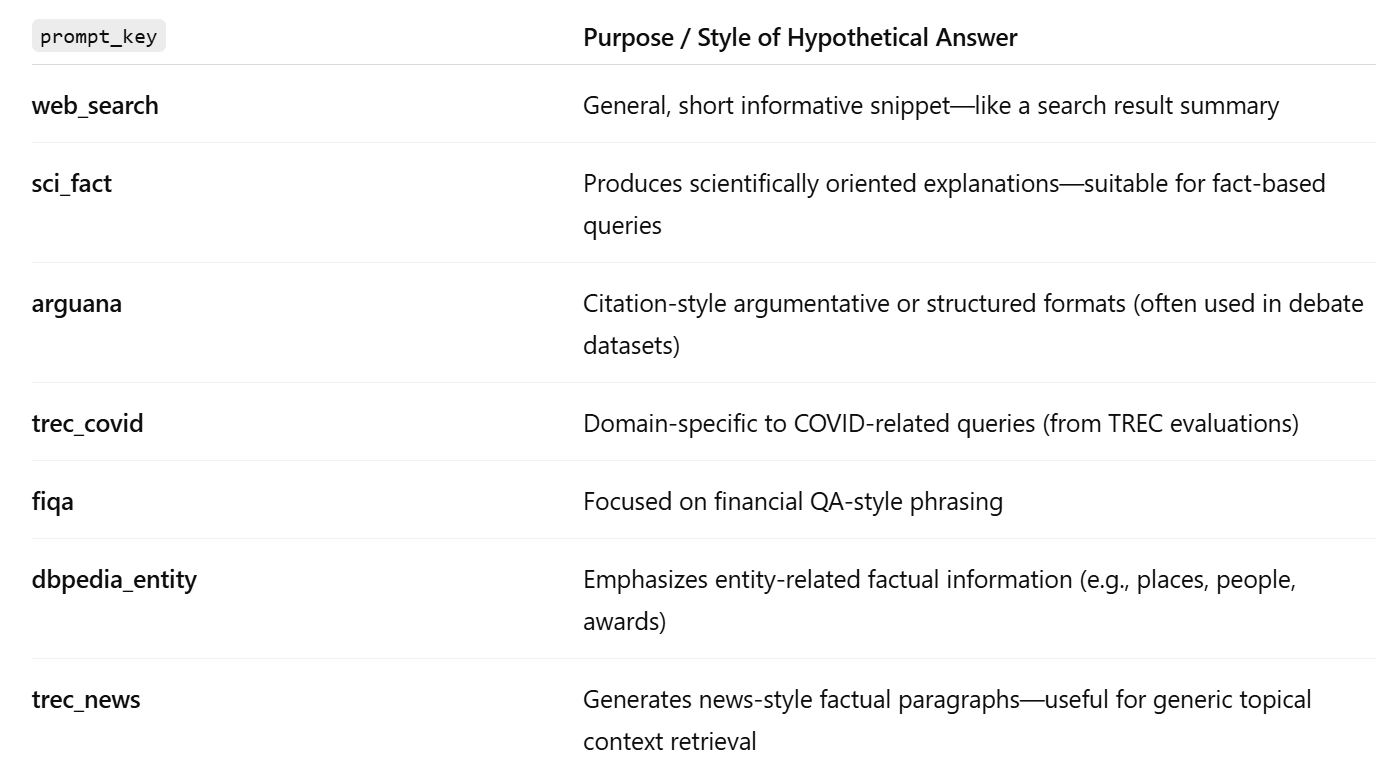

In [27]:
# Step 3: HyDE Embedder using prompt_key='web_search'
hyde_embedding_function = HypotheticalDocumentEmbedder.from_llm(
    llm=llm,
    base_embeddings=base_embeddings,
    prompt_key="web_search"
)

In [28]:
# Step 4: Store documents in Chroma with HyDE embeddings
vectorstore = Chroma.from_documents(
    documents=chunks,
    embedding=hyde_embedding_function,
    persist_directory="output/langchain"
)

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [29]:
# Step 5: RAG answer generation prompt
rag_prompt = PromptTemplate.from_template("""
Use the context below to answer the question.

Context:
{context}

Question: {input}
""")
rag_chain = create_stuff_documents_chain(llm=llm, prompt=rag_prompt)

In [32]:
# Step 6: Final RAG Pipeline
def hyde_rag_pipeline(query):
    matched_docs = vectorstore.similarity_search(query, k=4)
    print(matched_docs)
    response = rag_chain.invoke({
        "input": query,
        "context": matched_docs
    })
    return response

In [33]:
# Step 7: Run example query
query = "What memory modules does LangChain provide?"
answer = hyde_rag_pipeline(query)
print("✅ Final Answer:\n", answer)

[Document(metadata={'source': 'langchain_crewai_dataset.txt'}, page_content='LangChain offers memory modules like ConversationBufferMemory and ConversationSummaryMemory. These allow the LLM to maintain awareness of previous conversation turns or summarize long interactions to fit within token limits. (v6)'), Document(metadata={'source': 'langchain_crewai_dataset.txt'}, page_content='LangChain offers memory modules like ConversationBufferMemory and ConversationSummaryMemory. These allow the LLM to maintain awareness of previous conversation turns or summarize long interactions to fit within token limits. (v10)'), Document(metadata={'source': 'langchain_crewai_dataset.txt'}, page_content='LangChain offers memory modules like ConversationBufferMemory and ConversationSummaryMemory. These allow the LLM to maintain awareness of previous conversation turns or summarize long interactions to fit within token limits. (v2)'), Document(metadata={'source': 'langchain_crewai_dataset.txt'}, page_cont

### Custom Prompt

In [34]:
from langchain.prompts import PromptTemplate
custom = PromptTemplate.from_template(
    "Generate a concise hypothetical answer for this topic: {query}"
)

# Step 3: HyDE Embedder using prompt_key='web_search'
hyde_embedding_function = HypotheticalDocumentEmbedder.from_llm(
    llm=llm,
    base_embeddings=base_embeddings,
    custom_prompt=custom
)